# Progetto preliminare all'esame orale - Data Intensive Application

_Elia Marcantognini matr. 826126_

## Setup

- Importo i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os.path
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from mpl_toolkits import mplot3d
%matplotlib inline

## Descrizione del problema
- Si vuole estrarre un modello di conoscenza utile a capire e predire il costo dell'assicurazione medica personale negli Stati Uniti D'America.
- L'obiettivo del progetto è quello di predire una variabile continua, conoscendo le sue features.
- Si fa riferimento a un dataset di pubblico dominio utilizzato come esempio nel libro
    - Machine Learning with R di **Brett Lantz**
- Il dataset è disponibile https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv

## Recupero dei dati

In [2]:
if not os.path.exists("insurance.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv",
                "insurance.csv")

In [3]:
insurance = pd.read_csv("insurance.csv")

## Esplorazione dei dati

In [4]:
insurance.shape

(1338, 7)

In [5]:
insurance.head(3).append(insurance.tail(3))

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [6]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
# controllo la presenza di dati NaN
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Lista delle variabili
- `AGE`: età del contraente;
- `SEX`: genere del contraente;
- `BMI`: indice di massa corporea, utile per capire la fisicità del contraente;
- `CHILDREN`: numero di figli del contraente;
- `SMOKER`: indica se il contraente fuma, variabile binaria [yes, no];
- `REGION`: indica la regione di residenza del contraente.
- **`CHARGES`**: costo dell'assicurazione medica individuale
    - Lo scopo dell'analisi sarà quello di trovare un modello in grado di predire questa variabile in funzione delle altre.

Le features presenti sono di tipo categorico, continuo o discreto.
- Le categoriche sono: `sex`, `smoker` e `region`
- Le continue sono: `age` e `bmi`
- La discreta è: `children`

### Conversione dati categorici

In [8]:
insurance_data = insurance

**Per utilità e risparmio di spazio, creiamo una nuova instanza del dataset in cui convertiamo:**
- La colonna `sex`: 0 per 'female', 1 per 'male'
- La colonna `smoker`: 0 per 'no', 1 per 'yes'
- La colonna `region`: quattro colonne binarie, una per ogni regione

In [9]:
# sex
insurance_data['sex'] = insurance_data['sex'].map({'female':0, 'male':1})
# smoker
insurance_data['smoker'] = insurance_data['smoker'].map({'no':0, 'yes':1})
# region
insurance_data = pd.get_dummies(insurance_data, 'region')
# output
insurance_data.head(5)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


### Variabili categoriche

- Prendiamo in esame la feature `sex`

1    676
0    662
Name: sex, dtype: int64

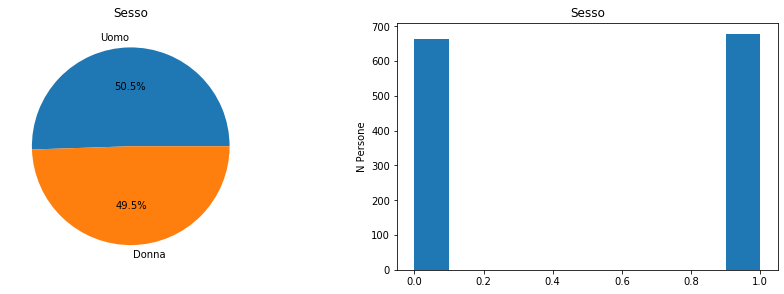

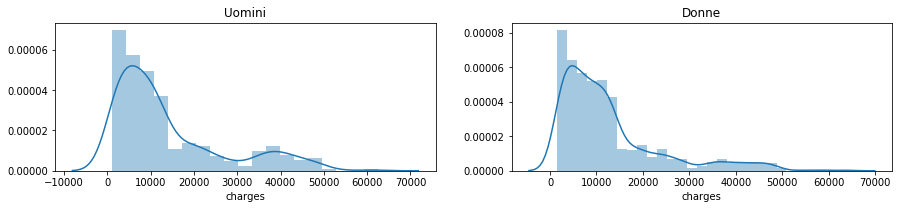

In [10]:
plt.figure(figsize=(15, 10))
# Distribuzione dei sessi
plt.subplot(2, 2, 1)
plt.title('Sesso')
plt.pie(insurance.sex.value_counts(), autopct='%1.1f%%', labels=['Uomo','Donna']);
plt.subplot(2, 2, 2)
plt.title('Sesso')
plt.ylabel('N Persone')
plt.hist(insurance.sex);
# Grafici di distribuzione
man = insurance.loc[insurance_data.sex == 1]
woman = insurance.loc[insurance_data.sex == 0]
plt.figure(figsize=(15,6))
sns.distplot(man['charges'], ax=plt.subplot(2,2,3)).set_title(label='Uomini')
sns.distplot(woman['charges'], ax=plt.subplot(2,2,4)).set_title(label='Donne');
insurance.sex.value_counts()

- Uomini e donne sono praticamente in egual numero all'interno del dataset
- Si può notare che i costi non sono strettamente correlati al sesso, controlliamo calcolando il coefficiente di correlazione di Pearson

In [11]:
# funzione che calcola il coefficiente di correlazione di Pearson
def correlation(a, b):
    return np.mean((a-a.mean()) * (b-b.mean())) / (a.std() * b.std())

In [12]:
correlation(insurance_data.sex, insurance.charges)

0.057249243022502776

- Effettivamente il coefficiente di correlazione è prossimo allo 0, indicando quindi assenza di correlazione

- Prendiamo ora in esame la feature `smoker`

0    1064
1     274
Name: smoker, dtype: int64

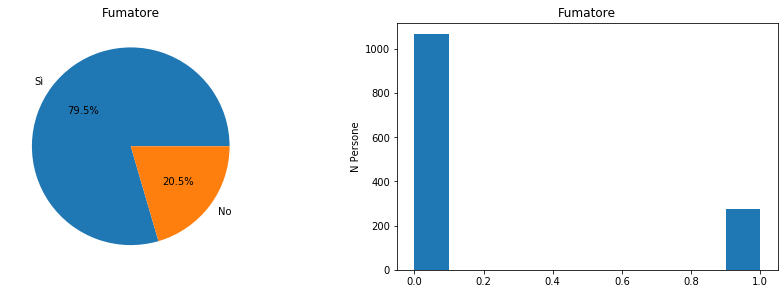

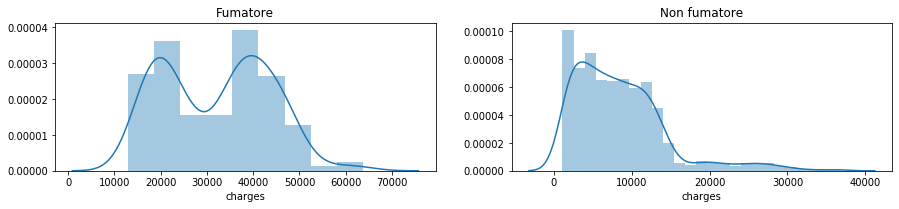

In [13]:
plt.figure(figsize=(15, 10))
# Distribuzione dei fumatori
plt.subplot(2, 2, 1)
plt.title('Fumatore')
plt.pie(insurance.smoker.value_counts(), autopct='%1.1f%%', labels=['Sì','No']);

plt.subplot(2, 2, 2)
plt.title('Fumatore')
plt.ylabel('N Persone')
plt.hist(insurance.smoker)

smoke = insurance_data.loc[insurance_data.smoker == 1]
not_smoke = insurance_data.loc[insurance_data.smoker == 0]
plt.figure(figsize=(15,6))
sns.distplot(smoke['charges'], ax=plt.subplot(2,2,3)).set_title(label='Fumatore')
sns.distplot(not_smoke['charges'], ax=plt.subplot(2,2,4)).set_title(label='Non fumatore');
insurance.smoker.value_counts()


- Nel dataset sono presenti molti più persone fumatrici che non
- Per quanto riguarda la feature `smoker`, sembra esserci una forte correlazione fra l'aumento del costo e un paziente fumatore.

In [14]:
correlation(insurance_data.smoker, insurance_data.charges)

0.7866630512529551

- Effettivamente è risultato un coefficiente prossimo all'1, indicando quindi una correlazione abbastanza forte

- Prendiamo ora in esame la feature `region`

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

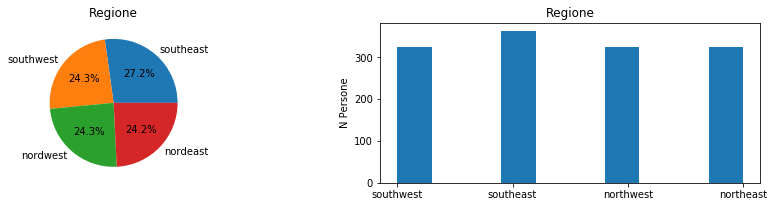

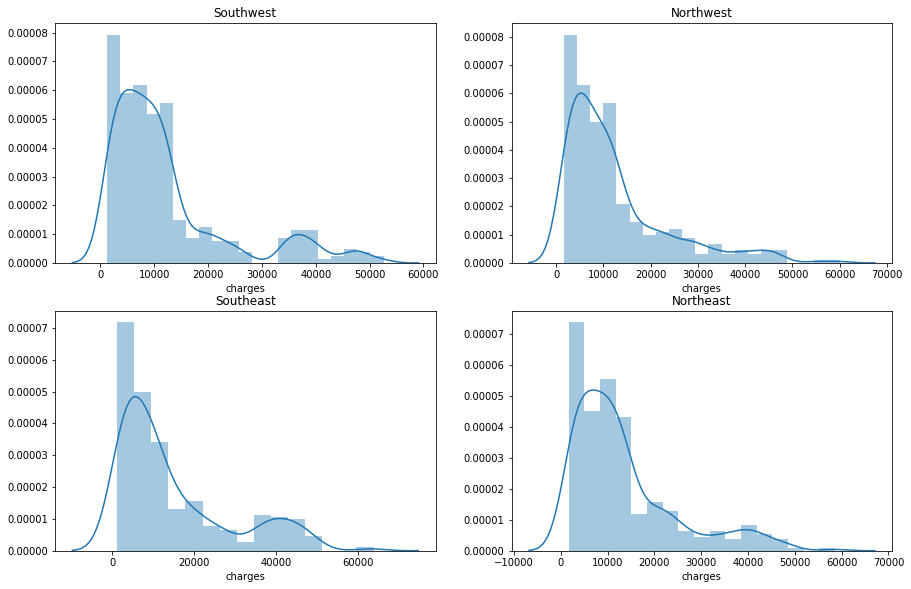

In [15]:
plt.figure(figsize=(15, 10))
# Distribuzione delle regioni
plt.subplot(3, 2, 1)
plt.title('Regione')
plt.pie(insurance.region.value_counts(), autopct='%1.1f%%', labels=[ 'southeast', 'southwest', 'nordwest', 'nordeast']);
plt.subplot(3, 2, 2)
plt.title('Regione')
plt.ylabel('N Persone')
plt.hist(insurance.region)

southwest = insurance.loc[insurance.region == 'southwest']
northwest = insurance.loc[insurance.region == 'northwest']
southeast = insurance.loc[insurance.region == 'southeast']
northeast = insurance.loc[insurance.region == 'northeast']
plt.figure(figsize=(15,15))
sns.distplot(southwest['charges'], ax=plt.subplot(3,2,3)).set_title(label='Southwest')
sns.distplot(northwest['charges'], ax=plt.subplot(3,2,4)).set_title(label='Northwest')
sns.distplot(southeast['charges'], ax=plt.subplot(3,2,5)).set_title(label='Southeast')
sns.distplot(northeast['charges'], ax=plt.subplot(3,2,6)).set_title(label='Northeast');
insurance.region.value_counts()

In [16]:
print("Coefficiente di correlazione:")
print("Southwest {:.5}".format(correlation(insurance_data.region_southwest, insurance_data.charges)))
print("Northwest {:.5}".format(correlation(insurance_data.region_northwest, insurance_data.charges)))
print("Southeast {:.5}".format(correlation(insurance_data.region_southeast, insurance_data.charges)))
print("Northeast {:.5}".format(correlation(insurance_data.region_northeast, insurance_data.charges)))

Coefficiente di correlazione:
Southwest -0.043178
Northwest -0.039875
Southeast 0.073926
Northeast 0.006344


- Come si può intuire dai risultati, le singole regioni non sono strettamente legate all'aumento o alla diminuizione del costo

Dallo studio delle variabili categoriche possiamo capire come solamente la feature `smoker` abbia un impatto importante nella determinazione della variabile `charges`.
Passiamo ora alle variabili continue.

### Variabili continue

Analizziamo la colonna `age`

18    69
19    68
Name: age, dtype: int64

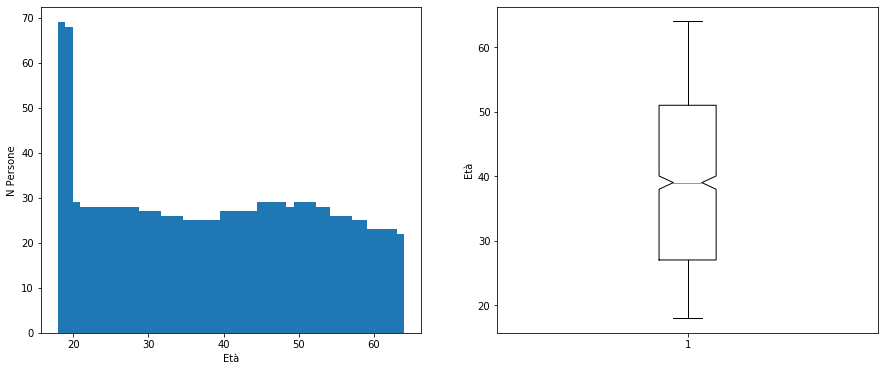

In [17]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.hist(insurance_data.age, bins=47)
plt.ylabel('N Persone')
plt.xlabel('Età')

plt.subplot(1,2,2)
plt.ylabel('Età')
plt.boxplot(insurance_data.age, notch=True)
insurance_data.loc[insurance.age < 20].age.value_counts()

- Come si può notare dal grafico, si ha una distribuzione dell'età equa delle sottoscrizioni dell'assicurazione medica
- Fatta eccezione per i contraenti con 18 e 19 anni
- Un'età maggiore influenzerà il costo?

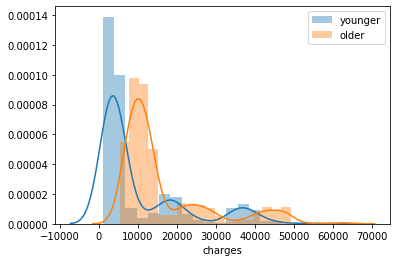

In [18]:
middle_age = np.round(insurance.age.mean()) # 39.207025 --> 39
sns.distplot(insurance.loc[insurance.age <= middle_age ]['charges'])
sns.distplot(insurance.loc[insurance.age > middle_age]['charges'])
plt.legend(['younger', 'older']);

- Una maggiore età sicuramente influenza il minimo della nostra variabile obiettivo, ma non la influenza globalmente.
- Ci aspettiamo un coefficiente di correlazione superiore allo 0 ma non molto alto

In [19]:
correlation(insurance.age, insurance.charges)

0.29878471934460105

##### Analisi della colonna `bmi`
- L'indice di massa corporea è rappresentativo della fisicità ($\frac{Altezza}{peso^2}$) di una persona

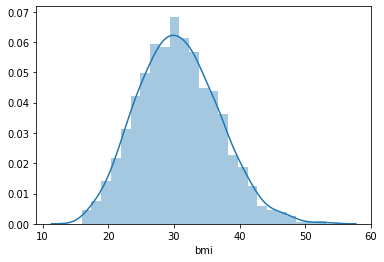

In [20]:
sns.distplot(insurance.bmi);

- La maggioranza delle persone prese in esame ha un BMI superiore a `24.9`, indice massimo del normopeso
- La media è 30, indice di obesità

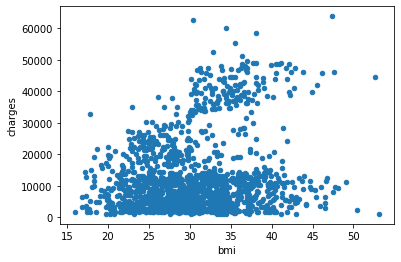

In [21]:
insurance_data.plot.scatter('bmi', 'charges');

- Si può già notare come un BMI superiore al normopeso possa essere indice di un aumento del costo dell'assicurazione
- Andiamo a studiare nel dettaglio il costo per chi è entro il normopeso e per chi non lo è

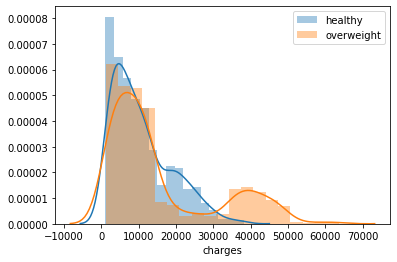

In [22]:
healthy = insurance.loc[insurance.bmi < 30]
overweight = insurance.loc[insurance.bmi >= 30]

sns.distplot(healthy['charges'])
sns.distplot(overweight['charges'])
plt.legend(['healthy', 'overweight']);

- I pazienti con un BMI superiore a 30 hanno un costo maggiore, come da aspettativa

In [23]:
correlation(insurance.bmi, insurance.charges)

0.19819273193614506

### Variabili discrete

##### Analisi della colonna `children`

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

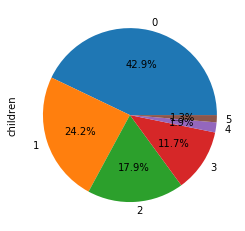

In [24]:
insurance['children'].value_counts().plot.pie(autopct='%1.1f%%');
insurance['children'].value_counts()

- La maggiorparte dei soggetti non ha figli (42.9%)
- Una minima parte dei soggetti ha fra i 3 e i 5 figli (<15%)

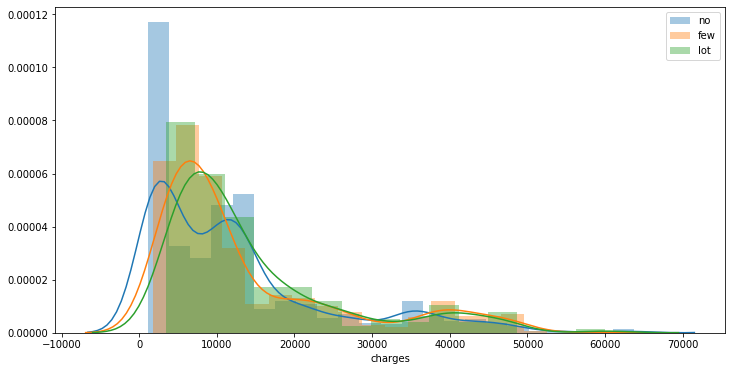

In [25]:
plt.figure(figsize=(12, 6))
no_children = insurance.loc[insurance.children == 0]
few_children = insurance.loc[(insurance.children > 0) & (insurance.children < 3)]
lot_children = insurance.loc[insurance.children >= 3]
sns.distplot(no_children['charges'])
sns.distplot(few_children['charges'])
sns.distplot(lot_children['charges'])
plt.legend(['no', 'few', 'lot']);

- Il numero di figli non sembra far aumentare i costi direttamente, piuttosto un aumento molto leggero del minimo valore della nostra variabile obiettivo
- Di conseguenza, ci aspettiamo un coefficiente di correlazione prossimo allo 0 e minore rispetto a quello calcolato sull'età

In [26]:
correlation(insurance.children, insurance.charges)

0.0679474060505599

## Matrice di correlazione

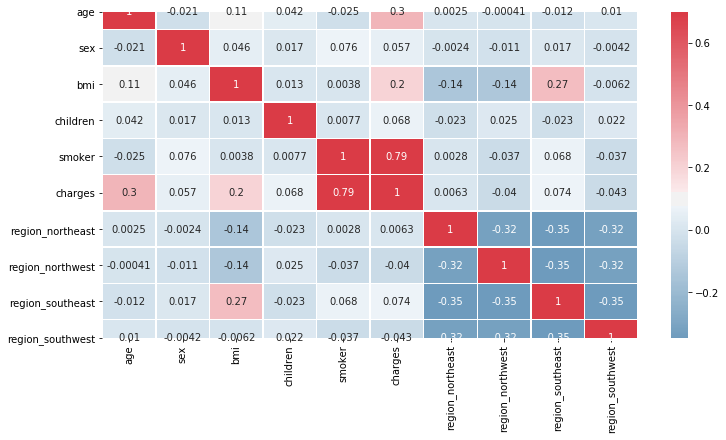

In [27]:
plt.figure(figsize=(12,6))
sns.heatmap(
            # matrice di correlazione
            insurance_data.corr(),
            # color map
            cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True),
            # Annotazione sulla casella
            annot = True,
            # valore massimo e minimo
            vmax=.7,
            # larghezza delle linee
            linewidths=.5,
            # 
            center=.1
);

- La matrice delle correlazioni ci conferma quanto visto finora
- Possiamo notare come non ci siano particolari correlazioni fra le features

## Preparazione dei dati

- Estraiamo dal nostro dataset
    - La Series `y` contenente i valori della colonna `charges` da predire
    - Il DataFrame `X` con i valori di tutte le altre colonne, utili per la predizione

In [28]:
y = insurance_data['charges']
X = insurance_data.drop(columns='charges')

In [29]:
y.head(3).append(y.tail(3))

0       16884.9240
1        1725.5523
2        4449.4620
1335     1629.8335
1336     2007.9450
1337    29141.3603
Name: charges, dtype: float64

In [30]:
X.head(3).append(X.tail(3))

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,0,0,0,1
1,18,1,33.77,1,0,0,0,1,0
2,28,1,33.00,3,0,0,0,1,0
1335,18,0,36.85,0,0,0,0,1,0
1336,21,0,25.80,0,0,0,0,0,1
1337,61,0,29.07,0,1,0,1,0,0


- Dividiamo il dataset in training e validation set attraverso il metodo _hold out_

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

## Modelli

In [32]:
# definisco funzione per errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# funzione per calcolare e stampare tutte e tre
def print_eval(model):
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    re = relative_error(y_val, preds)
    r2 = model.score(X_val, y_val)*100
    plt.figure(figsize=(12, 6))
    sns.distplot(preds)
    sns.distplot(y_val)
    plt.legend(['preds', 'y_val'])
    print("   Mean squared error: {:.5}".format(mse))
    print("       Relative error: {:.5%}".format(re))
    print('R^2|Accuracy on train: {:.2f}%'.format(model.score(X_train, y_train)*100))
    print('R^2|  Accuracy on val: {:.2f}%'.format(r2))
    return mse, re, r2

# funzione per salvare i risultati dei vari modelli in un unico DF, utile per il confronto alla fine
results = pd.DataFrame(data={}, columns=['model', 'mse', 're', 'r2'])
def save_results(name='-', mse=0, re=0, r2=0):
    data = {'model': [name], 'mse': [mse], 're': [re], 'r2': [r2]}
    global results
    results = results.append(pd.DataFrame(data), ignore_index=True)

# definisco i fold per la cross validation
kf = KFold(5, shuffle=True, random_state=42)

- Per prima cosa, studiamo se utilizzando la regressione Lasso siamo in grado di eliminare qualche feature perché poco rilevane

### Regressione Lasso

In [33]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("reg", Lasso())
])
#model.fit(X_train, y_train)
#print_eval(model)
#pd.Series(model.named_steps["regr"].coef_, X.columns)
grid = {'reg__alpha' : [0.01, 0.1, 1, 10]}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print('Best params: ', gs.best_params_)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

Best params:  {'reg__alpha': 10}


G:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 724196970.7898941, tolerance: 10345431.238869607
  positive)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.002393,0.000489,0.000798,3.989220e-04,10,{'reg__alpha': 10},0.794374,0.702791,0.755244,0.760163,0.686981,0.739930,0.039491,1
2,0.002593,0.000488,0.000997,1.784161e-07,1,{'reg__alpha': 1},0.794372,0.702783,0.755389,0.759915,0.686799,0.739871,0.039527,2
1,0.002992,0.001093,0.000798,3.989458e-04,0.1,{'reg__alpha': 0.1},0.794370,0.702781,0.755403,0.759889,0.686778,0.739864,0.039531,3
0,0.003989,0.001093,0.000997,6.309018e-04,0.01,{'reg__alpha': 0.01},0.794370,0.702780,0.755404,0.759886,0.686777,0.739863,0.039532,4


   Mean squared error: 3.4973e+07
       Relative error: 43.40228%
R^2|Accuracy on train: 74.31%
R^2|  Accuracy on val: 76.50%


age                 3705.745951
sex                   51.894507
bmi                 2057.399690
children             435.166988
smoker              9589.296822
region_northeast     319.953261
region_northwest     157.855850
region_southeast     -47.028111
region_southwest     -23.625725
dtype: float64

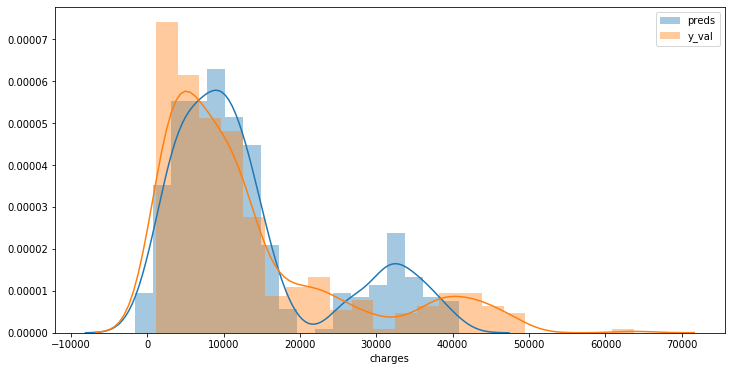

In [34]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("reg", Lasso(alpha=10))
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('Lasso', mse, re, r2)
pd.Series(model.named_steps["reg"].coef_, X.columns)

### Regressione Lineare

   Mean squared error: 3.4966e+07
       Relative error: 43.39944%
R^2|Accuracy on train: 74.31%
R^2|  Accuracy on val: 76.50%


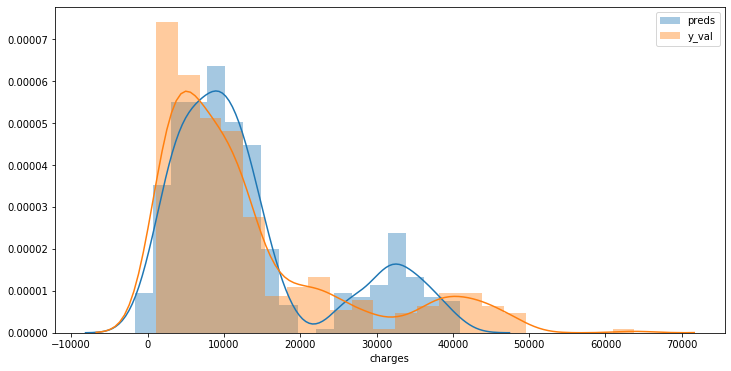

In [35]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)
mse, re, r2 = print_eval(model)
save_results('LinReg', mse, re, r2)

   Mean squared error: 3.4962e+07
       Relative error: 43.37917%
R^2|Accuracy on train: 74.31%
R^2|  Accuracy on val: 76.51%


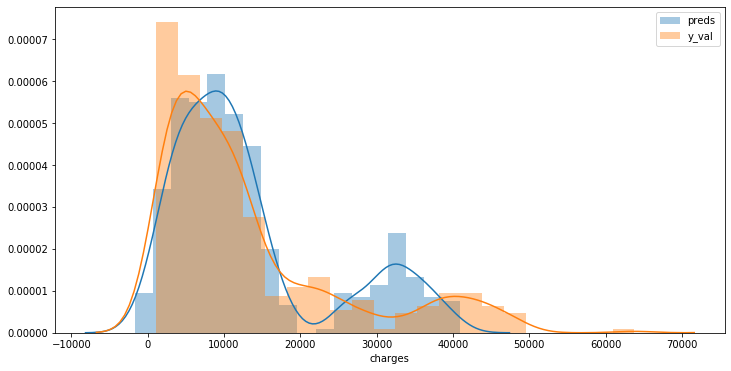

In [36]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)
mse, re, r2 = print_eval(model)
save_results('LinRegScale', mse, re, r2)

### Regressione Polinomiale

   Mean squared error: 2.166e+07
       Relative error: 28.95865%
R^2|Accuracy on train: 84.14%
R^2|  Accuracy on val: 85.45%


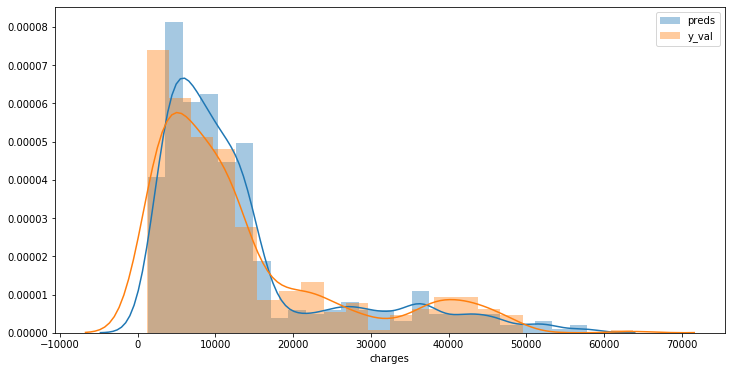

In [37]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('Poly', mse, re, r2)

   Mean squared error: 2.1662e+07
       Relative error: 28.85292%
R^2|Accuracy on train: 84.14%
R^2|  Accuracy on val: 85.44%


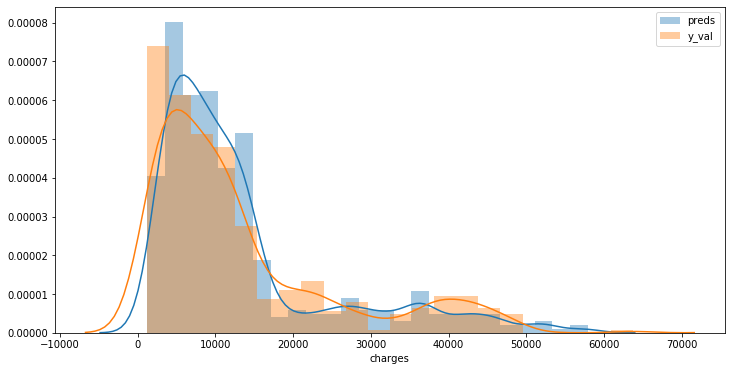

In [38]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('PolyScale', mse, re, r2)

- Ora controlliamo se ci sia possibilità di migliorare ancora il modello con un grado polinomiale più alto

In [47]:
model = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
grid = {
    'poly__degree': range(1, 10)
    }
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print('Best params: ', gs.best_params_)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

Best params:  {'poly__degree': 2}


G:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.004189,0.000747,0.001795,0.000399,2,{'poly__degree': 2},8.847341e-01,7.842682e-01,8.433217e-01,8.649797e-01,7.713034e-01,8.297321e-01,4.458574e-02,1
2,0.015559,0.002239,0.003292,0.000400,3,{'poly__degree': 3},8.667882e-01,7.532988e-01,8.359775e-01,8.391001e-01,7.582406e-01,8.106796e-01,4.615308e-02,2
0,0.014162,0.022842,0.001197,0.000399,1,{'poly__degree': 1},7.943704e-01,7.027796e-01,7.554044e-01,7.593564e-01,6.885668e-01,7.401145e-01,3.900273e-02,3
3,0.058643,0.001323,0.009575,0.001017,4,{'poly__degree': 4},5.829059e-01,5.589769e-01,7.188716e-01,6.945165e-01,6.374877e-01,6.384001e-01,6.168174e-02,4
7,1.665482,0.015684,0.270679,0.007480,8,{'poly__degree': 8},-2.107160e+09,-1.587052e+10,-1.893582e+09,-1.448079e+08,-1.932567e+09,-4.400040e+09,5.791354e+09,5
8,3.907149,0.275043,0.579064,0.041341,9,{'poly__degree': 9},-8.299091e+08,-5.047733e+08,-2.142884e+10,-6.364179e+07,-3.760536e+08,-4.631734e+09,8.390381e+09,6
6,0.793891,0.020639,0.139831,0.007289,7,{'poly__degree': 7},-4.218125e+14,-1.275062e+16,-2.906163e+17,-7.308071e+13,-7.358186e+13,-6.066554e+16,1.149175e+17,7
4,0.185508,0.006827,0.024138,0.001432,5,{'poly__degree': 5},-1.995216e+01,-1.577434e+18,-8.645740e+04,-6.202577e+17,-3.417737e+01,-4.403212e+17,6.182409e+17,8
5,0.359248,0.006789,0.056050,0.002706,6,{'poly__degree': 6},-1.213145e+15,-3.772962e+16,-9.321667e+18,-9.343873e+15,-1.701490e+14,-1.869866e+18,3.720703e+18,9


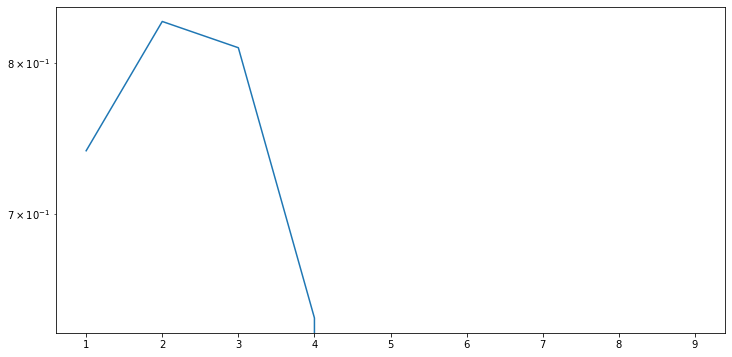

In [63]:
plt.figure(figsize=(12,6))
x = gs.cv_results_['param_poly__degree'].data
y = gs.cv_results_['mean_test_score']
plt.yscale('log')
plt.plot(x, y);

- Possiamo notare come la soluzione migliore sia effettivamente quella con polinomio di grado 2.
- Lo score infatti è minore con grado pari a 1 (il risultato della regressione lineare) 
- Lo score precipita se si aumenta il grado

### Regressione Ridge

   Mean squared error: 3.5001e+07
       Relative error: 43.61971%
R^2|Accuracy on train: 74.31%
R^2|  Accuracy on val: 76.48%


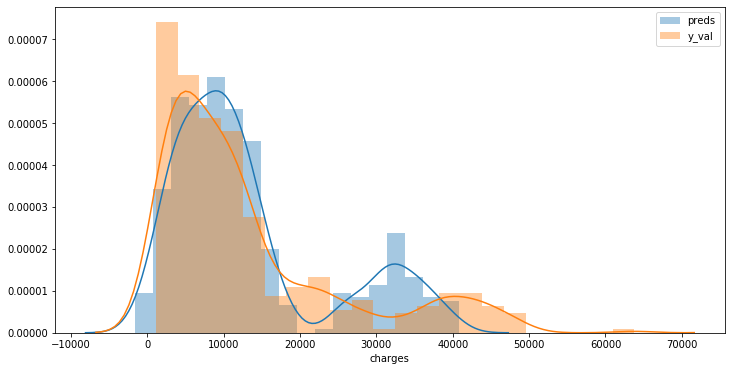

In [39]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('Ridge', mse, re, r2)

- Finora abbiamo visto che il modello migliore è quello polinomiale, proviamo a introdurre una regolarizzazione utilizzando una funzione Kernel di tipo polinomiale alla regressione Ridge
- Ora testiamo, utilizzando la Grid Search e la K Fold Validation, il modello per cercare dei paremetri migliori, se ne esistono
- Testiamo sia la regolarizzazione con kernel polinomiale che con kernel RBF (_Radial Basis Function_)

In [40]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge())
])
grid = {
    'reg__kernel': ['poly'],
    'reg__degree': range(1, 5),
    'reg__alpha': [0.01, 0.1, 1, 10],
    }, {
    'reg__kernel': ['rbf'],
    'reg__alpha': [0.01, 0.1, 1, 10],
    'reg__gamma': [0.01, 0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print('Best params: ', gs.best_params_)

Best params:  {'reg__alpha': 0.01, 'reg__gamma': 0.01, 'reg__kernel': 'rbf'}


G:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[:2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,param_reg__degree,param_reg__kernel,param_reg__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,0.017056,0.001111,0.003391,0.000489,0.01,NaN,rbf,0.01,"{'reg__alpha': 0.01, 'reg__gamma': 0.01, 'reg_...",0.886910,0.787346,0.846812,0.866174,0.771700,0.831801,0.044806,1
9,0.015460,0.001094,0.002194,0.000399,1,2,poly,NaN,"{'reg__alpha': 1, 'reg__degree': 2, 'reg__kern...",0.884446,0.788276,0.842273,0.866187,0.772676,0.830784,0.043482,2


- La grid search ci indica che il risultato migliore si ottiene con kernel rbf
- Però anche la soluzione con kernel poly non si discosta molto, testiamole entrambe

   Mean squared error: 2.1347e+07
       Relative error: 29.72461%
R^2|Accuracy on train: 85.01%
R^2|  Accuracy on val: 85.66%


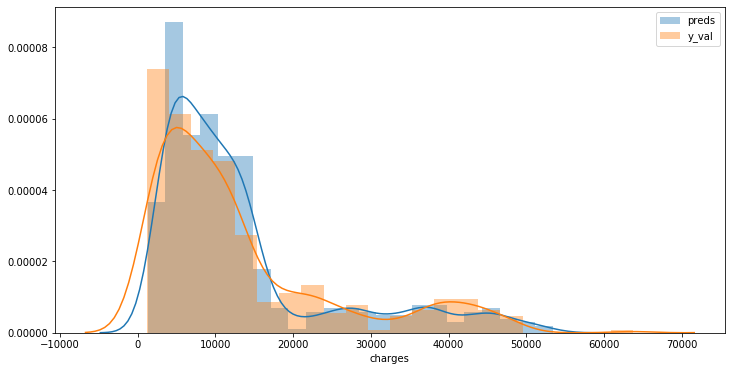

In [42]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='rbf', gamma=0.01, alpha=0.01))
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('KernelSBF', mse, re, r2)

   Mean squared error: 2.166e+07
       Relative error: 28.96053%
R^2|Accuracy on train: 84.14%
R^2|  Accuracy on val: 85.45%


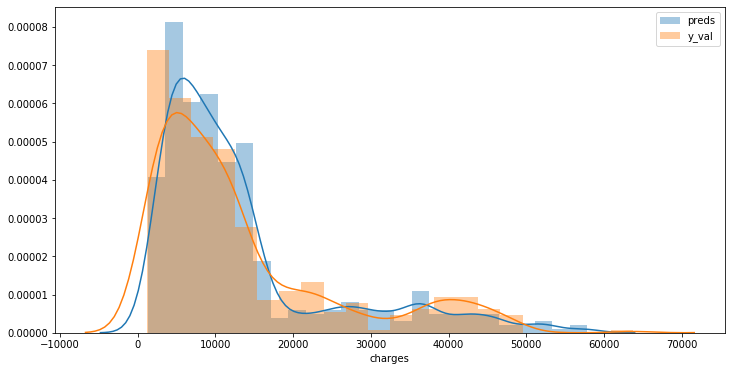

In [43]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='poly', degree=2, alpha=0.01))
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('KernelPoly', mse, re, r2)

## Confronto fra modelli

In [44]:
results.sort_values('r2', ascending=False)

,model,mse,re,r2
6,KernelSBF,2.134745e+07,0.297246,85.655537
7,KernelPoly,2.165977e+07,0.289605,85.445675
3,Poly,2.166019e+07,0.289586,85.445391
4,PolyScale,2.166154e+07,0.288529,85.444484
2,LinRegScale,3.496205e+07,0.433792,76.507177
1,LinReg,3.496628e+07,0.433994,76.504336
0,Lasso,3.497329e+07,0.434023,76.499625
5,Ridge,3.500065e+07,0.436197,76.481240


In [45]:
results.sort_values('re')

,model,mse,re,r2
4,PolyScale,2.166154e+07,0.288529,85.444484
3,Poly,2.166019e+07,0.289586,85.445391
7,KernelPoly,2.165977e+07,0.289605,85.445675
6,KernelSBF,2.134745e+07,0.297246,85.655537
2,LinRegScale,3.496205e+07,0.433792,76.507177
1,LinReg,3.496628e+07,0.433994,76.504336
0,Lasso,3.497329e+07,0.434023,76.499625
5,Ridge,3.500065e+07,0.436197,76.481240
